<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 1.5MB 15.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!pip install -q -U tfx

     |████████████████████████████████| 2.3 MB 19.9 MB/s 
     |████████████████████████████████| 17.7 MB 84 kB/s 
     |████████████████████████████████| 1.7 MB 61.2 MB/s 
     |████████████████████████████████| 2.9 MB 71.2 MB/s 
     |████████████████████████████████| 1.2 MB 68.0 MB/s 
     |████████████████████████████████| 9.0 MB 59.5 MB/s 
     |████████████████████████████████| 103 kB 62.9 MB/s 
     |████████████████████████████████| 400 kB 67.8 MB/s 
     |████████████████████████████████| 147 kB 76.5 MB/s 
     |████████████████████████████████| 1.5 MB 72.9 MB/s 
     |████████████████████████████████| 2.2 MB 64.4 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 48.8 MB/s 
     |████████████████████████████████| 89 kB 10.6 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 61 kB 9.7 MB/s 
     |████████████████████████████████| 2.2 MB 62.4 MB/s 
     |████████████████

In [3]:
!pip install tensorflow==1.2

ERROR: Could not find a version that satisfies the requirement tensorflow==1.2
ERROR: No matching distribution found for tensorflow==1.2


In [4]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [1]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

In [2]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.4.1
TFX version: 0.29.0


In [3]:
# This is the root directory for your TFX pip package installation.
_tfx_root = tfx.__path__[0]

# This is the directory containing the TFX Chicago Taxi Pipeline example.
_taxi_root = os.path.join(_tfx_root, 'examples/chicago_taxi_pipeline')

# This is the path where your model will be pushed for serving.
_serving_model_dir = os.path.join(
    tempfile.mkdtemp(), 'serving_model/taxi_simple')

# Set up logging.
absl.logging.set_verbosity(absl.logging.INFO)

In [4]:
_data_root = tempfile.mkdtemp(prefix='tfx-data')
DATA_PATH = 'https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv'
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('/tmp/tfx-datavun_95gc/data.csv', <http.client.HTTPMessage at 0x7f373c01aa50>)

In [5]:
!head {_data_filepath}

pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
,12.45,5,19,6,1400269500,,,,,0.0,,,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0,,0.0
,0,3,19,5,1362683700,,,,,0,,,Unknown,Chicago Elite Cab Corp.,300,,0
60,27.05,10,2,3,1380593700,41.836150155,-87.648787952,,,12.6,,,Cash,Taxi Affiliation Services,1380,,0.0
10,5.85,10,1,2,1382319000,41.985015101,-87.804532006,,,0.0,,,Cash,Taxi Affiliation Services,180,,0.0
14,16.65,5,7,5,1369897200,41.968069,-87.721559063,,,0.0,,,Cash,Dispatch Taxi Affiliation,1080,,0.0
13,16.45,11,12,3,1446554700,41.983636307,-87.723583185,,,6.9,,,Cash,,780,,0.0
16,32.05,12,1,1,1417916700,41.953582125,-87.72345239,,,15.4,,,Cash,,1200,,0.0
30,38.45,10,10,5,1444301100,41.839086906,-87.714003807,,,14.6,,,Cash,,2580,,0.0
11,14.65,1,1,3,1358

In [4]:
context = InteractiveContext()

In [7]:
example_gen = CsvExampleGen(input=external_input(_data_root))
context.run(example_gen)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.
INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.


INFO:absl:Processing input csv data /tmp/tfx-datavun_95gc/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:1922812,xor_checksum:1618734378,sum_checksum:1618734378"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [8]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/CsvExampleGen/examples/1


In [5]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle competitions download -c nyc-taxi-trip-duration

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip = '/content/train.zip'
zip1 = zipfile.ZipFile(zip, 'r')
zip1.extractall('/content/train')
zip1.close()

In [8]:
import tensorflow as tf
from tensorflow.keras.experimental import WideDeepModel, LinearModel
import keras
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [9]:
df = pd.read_csv('/content/train/train.csv')[:15000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  15000 non-null  object 
 1   vendor_id           15000 non-null  int64  
 2   pickup_datetime     15000 non-null  object 
 3   dropoff_datetime    15000 non-null  object 
 4   passenger_count     15000 non-null  int64  
 5   pickup_longitude    15000 non-null  float64
 6   pickup_latitude     15000 non-null  float64
 7   dropoff_longitude   15000 non-null  float64
 8   dropoff_latitude    15000 non-null  float64
 9   store_and_fwd_flag  15000 non-null  object 
 10  trip_duration       15000 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.3+ MB


In [10]:
df_features = df.copy()
df_features['pickup_datetime'] = pd.to_datetime(df_features['pickup_datetime'])
df_features['month'] = df_features['pickup_datetime'].dt.month
df_features['day'] = df_features['pickup_datetime'].dt.day
df_features['hour'] = df_features['pickup_datetime'].dt.hour
df_features['distance'] = df_features.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).miles, axis=1)
df_features['trip_duration'] = df_features['trip_duration'] / 60.
df_features.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,3,14,17,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,6,12,0,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,1,19,11,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,4,6,19,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,3,26,13,0.737591
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,7.383333,1,30,22,0.683275
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,5.683333,6,17,22,0.824764
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,25.850000,5,21,7,3.553009
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,4.250000,5,27,23,0.815587
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,20.416667,3,10,21,3.178194


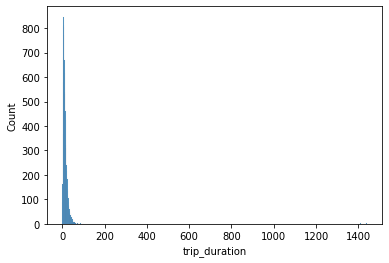

In [11]:
ax = sns.histplot(data=df_features, x="trip_duration")

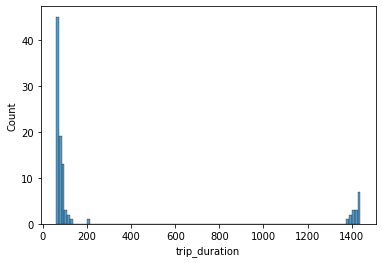

In [12]:
ax = sns.histplot(data=df_features[df_features['trip_duration'] > 60], x="trip_duration")

## Train

In [13]:
label_col = 'trip_duration'

X_deep = df_features[['passenger_count', 'distance']].to_numpy()
X_wide = df_features[['month', 'day']].to_numpy()
y = df_features[[label_col]].to_numpy()

In [14]:
epochs = 10

In [15]:
linear_model = LinearModel()
linear_model.compile('adagrad', 'mse')
linear_model.fit(X_wide, y, epochs)
dnn_model = keras.Sequential([keras.layers.Dense(units=2)])
dnn_model.compile('rmsprop', 'mse')
dnn_model.fit(X_deep, y, epochs)
combined_model = WideDeepModel(linear_model, dnn_model)
combined_model.compile(optimizer='adam', loss='mse')
history = combined_model.fit([X_wide, X_deep], y, epochs)

1500/1500 [==============================] - 3s 2ms/step - loss: 2535.1116


## TFX Interactive pipeline

In [16]:
!mkdir -p /content/temp
!head -n 30000 {'/content/train/train.csv'} > {'/content/temp/train.csv'}

In [17]:
TRAIN_DIR = '/content/temp'

In [18]:
example_gen = CsvExampleGen(input=external_input(TRAIN_DIR))
context.run(example_gen)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.
INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.


INFO:absl:Processing input csv data /content/temp/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:4125486,xor_checksum:1618736520,sum_checksum:1618736520"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [19]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "dropoff_datetime"
    value {
      bytes_list {
        value: "2016-03-14 17:32:30"
      }
    }
  }
  feature {
    key: "dropoff_latitude"
    value {
      float_list {
        value: 40.765602111816406
      }
    }
  }
  feature {
    key: "dropoff_longitude"
    value {
      float_list {
        value: -73.96463012695312
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "id2875421"
      }
    }
  }
  feature {
    key: "passenger_count"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "pickup_datetime"
    value {
      bytes_list {
        value: "2016-03-14 17:24:55"
      }
    }
  }
  feature {
    key: "pickup_latitude"
    value {
      float_list {
        value: 40.76793670654297
      }
    }
  }
  feature {
    key: "pickup_longitude"
    value {
      float_list {
        value: -73.9821548461914
      }
    }
  }
  feature {
    key: "store_and_fwd_flag"

In [20]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for StatisticsGen
INFO:absl:Generating statistics for split train.
INFO:absl:Statistics for split train written to /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/StatisticsGen/statistics/2/Split-train.
INFO:absl:Generating statistics for split eval.
INFO:absl:Statistics for split eval written to /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/StatisticsGen/statistics/2/Split-eval.
INFO:absl:Running publisher for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 7
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [21]:
context.show(statistics_gen.outputs['statistics'])

## SchemaGen
The SchemaGen component generates a schema based on your data statistics. (A schema defines the expected bounds, types, and properties of the features in your dataset.) It also uses the TensorFlow Data Validation library.

Note: The generated schema is best-effort and only tries to infer basic properties of the data. It is expected that you review and modify it as needed.

SchemaGen will take as input the statistics that we generated with StatisticsGen, looking at the training split by default.

In [22]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)
context.show(schema_gen.outputs['schema'])

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for SchemaGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for SchemaGen
INFO:absl:Processing schema from statistics for split train.
INFO:absl:Processing schema from statistics for split eval.
INFO:absl:Schema written to /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/SchemaGen/schema/3/schema.pbtxt.
INFO:absl:Running publisher for SchemaGen
INFO:absl:MetadataStore with DB connection initialized


,Type,Presence,Valency,Domain
Feature name,,,,
'dropoff_datetime',BYTES,required,single,-
'id',BYTES,required,single,-
'pickup_datetime',BYTES,required,single,-
'store_and_fwd_flag',STRING,required,single,'store_and_fwd_flag'
'dropoff_latitude',FLOAT,required,single,-
'dropoff_longitude',FLOAT,required,single,-
'passenger_count',INT,required,single,-
'pickup_latitude',FLOAT,required,single,-
'pickup_longitude',FLOAT,required,single,-


In [23]:
_taxi_constants_module_file = 'taxi_constants.py'

In [24]:
%%writefile {_taxi_constants_module_file}

DENSE_FLOAT_FEATURE_KEYS = ['passenger_count']

FEATURE_BUCKET_COUNT = 10
BUCKET_FEATURE_KEYS = [
    'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
]

# 2016-01-19 11:35:24
MAX_CATEGORICAL_MONTH_VALUES = 12
MAX_CATEGORICAL_DAY_VALUES = 31
MAX_CATEGORICAL_HOUR_VALUES = 12
MAX_CATEGORICAL_MIN_VALUES = 60
MAX_CATEGORICAL_SEC_VALUES = 60

DATETIME_FEATURE_KEYS = [
    #  Date
    ('dropoff_datetime', 'dropoff_datetime_month', 5, 2, MAX_CATEGORICAL_MONTH_VALUES),
    ('dropoff_datetime', 'dropoff_datetime_day', 8, 2, MAX_CATEGORICAL_DAY_VALUES),
    ('pickup_datetime', 'pickup_datetime_month', 5, 2, MAX_CATEGORICAL_MONTH_VALUES),
    ('pickup_datetime', 'pickup_datetime_day', 8, 2, MAX_CATEGORICAL_DAY_VALUES),
    # Time
    ('dropoff_datetime', 'dropoff_datetime_hour', 11, 2, MAX_CATEGORICAL_HOUR_VALUES),
    ('dropoff_datetime', 'dropoff_datetime_min', 14, 2, MAX_CATEGORICAL_DAY_VALUES),
    ('dropoff_datetime', 'dropoff_datetime_sec', 17, 2, MAX_CATEGORICAL_SEC_VALUES),
    ('pickup_datetime', 'pickup_datetime_hour', 11, 2, MAX_CATEGORICAL_HOUR_VALUES),
    ('pickup_datetime', 'pickup_datetime_min', 14, 2, MAX_CATEGORICAL_DAY_VALUES),
    ('pickup_datetime', 'pickup_datetime_sec', 17, 2, MAX_CATEGORICAL_SEC_VALUES),
]

RIDE_DIST_KEY = 'ride_distance'

LABEL_KEY = 'trip_duration'

def transformed_name(key):
  return '{}_xf'.format(key)

Overwriting taxi_constants.py


## ExampleValidator
The ExampleValidator component detects anomalies in your data, based on the expectations defined by the schema. It also uses the TensorFlow Data Validation library.

ExampleValidator will take as input the statistics from StatisticsGen, and the schema from SchemaGen.

In [25]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for ExampleValidator
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for ExampleValidator
INFO:absl:Validating schema against the computed statistics for split train.
INFO:absl:Validation complete for split train. Anomalies written to /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/ExampleValidator/anomalies/4/Split-train.
INFO:absl:Validating schema against the computed statistics for split eval.
INFO:absl:Validation complete for split eval. Anomalies written to /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/ExampleValidator/anomalies/4/Split-eval.
INFO:absl:Running publisher for ExampleValidator
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 4
        type_id: 11
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/ExampleValidator/anomalies/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 11
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [26]:
context.show(example_validator.outputs['anomalies'])

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:188: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


## Transform
The Transform component performs feature engineering for both training and serving. It uses the TensorFlow Transform library.

Transform will take as input the data from ExampleGen, the schema from SchemaGen, as well as a module that contains user-defined Transform code.

Let's see an example of user-defined Transform code below (for an introduction to the TensorFlow Transform APIs, see the tutorial). First, we define a few constants for feature engineering:

Note: The %%writefile cell magic will save the contents of the cell as a .py file on disk. This allows the Transform component to load your code as a module.

In [27]:
_taxi_transform_module_file = 'taxi_transform.py'

In [28]:
%%writefile {_taxi_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import taxi_constants

_DENSE_FLOAT_FEATURE_KEYS = taxi_constants.DENSE_FLOAT_FEATURE_KEYS
_FEATURE_BUCKET_COUNT = taxi_constants.FEATURE_BUCKET_COUNT
_BUCKET_FEATURE_KEYS = taxi_constants.BUCKET_FEATURE_KEYS
_DATETIME_FEATURE_KEYS = taxi_constants.DATETIME_FEATURE_KEYS
_RIDE_DIST_KEY = taxi_constants.RIDE_DIST_KEY
_LABEL_KEY = taxi_constants.LABEL_KEY
_transformed_name = taxi_constants.transformed_name


def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}
  for key in _DENSE_FLOAT_FEATURE_KEYS:
    # Preserve this feature as a dense float, setting nan's to the mean.
    outputs[_transformed_name(key)] = tft.scale_to_z_score(_fill_in_missing(inputs[key]))

  for key in _BUCKET_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.bucketize(_fill_in_missing(inputs[key]), _FEATURE_BUCKET_COUNT)

  for datetime_features in _DATETIME_FEATURE_KEYS:
    (orig_feature, new_feature, start_post, substr_len, _) = datetime_features
    outputs[_transformed_name(new_feature)] = _convert_str_to_datetime(inputs[orig_feature], start_post, substr_len)


  outputs[_transformed_name(_RIDE_DIST_KEY)] = tft.scale_to_z_score(_dist_between_lat_long(
      _fill_in_missing(inputs['pickup_latitude']), _fill_in_missing(inputs['pickup_longitude']), 
      _fill_in_missing(inputs['dropoff_latitude']), _fill_in_missing(inputs['dropoff_longitude'])))

  # Label
  outputs[_transformed_name(_LABEL_KEY)] = tf.cast(tf.math.divide(_fill_in_missing(inputs[_LABEL_KEY]), tf.constant([60], dtype=tf.int64)), dtype=tf.int64)

  return outputs


def _fill_in_missing(x):
  """Replace missing values in a SparseTensor.
  Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
  Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
  Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
  """
  if not isinstance(x, tf.sparse.SparseTensor):
    return x

  default_value = '' if x.dtype == tf.string else 0
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

def _convert_str_to_datetime(x, start_post, substr_len):
  time_data = tf.strings.to_number(tf.strings.substr(x.values, start_post, substr_len))
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, time_data, [x.dense_shape[0], 1]), ),
      axis=1)

def _dist_between_lat_long(lat_a, long_a, lat_b, long_b):
  distance = tf.sqrt(
    tf.pow(lat_a - lat_b, 2) + tf.pow(long_a - long_b, 2)
  )
  return distance

Overwriting taxi_transform.py


In [29]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_taxi_transform_module_file))
context.run(transform)

INFO:absl:Running driver for Transform
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Transform
INFO:absl:Analyze the 'train' split and transform all splits when splits_config is not set.
INFO:absl:Loading source_path /content/taxi_transform.py as name user_module_0 because it has not been loaded before.
INFO:absl:/content/taxi_transform.py is already loaded, reloading
INFO:absl:Feature dropoff_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature id has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature store_and_fwd_flag has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature passenger_count has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_latitude has no s

Instructions for updating:
Use ref() instead.


INFO:absl:Feature dropoff_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature id has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature store_and_fwd_flag has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature passenger_count has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature trip_duration has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature vendor_id has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature id has no shape. Setting to VarLenSparseTensor

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/Transform/transform_graph/5/.temp_path/tftransform_tmp/1d736ff18b97404790a1ba8a657eb6d1/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mg

INFO:absl:Feature dropoff_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature id has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature store_and_fwd_flag has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature passenger_count has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature trip_duration has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature vendor_id has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature dropoff_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature id has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_datetime has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature store_and_fwd_flag has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature dropoff_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature passenger_count has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_latitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature pickup_longitude has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature trip_duration has no shape. Setting to VarLenSparseTensor.
INFO:absl:Feature vendor_id has no shape. Setting to VarLenSparseTensor.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/Transform/transform_graph/5/.temp_path/tftransform_tmp/e2cd5995f67e4a9db8974e1b8f68b369/saved_model.pb
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:absl:Running publisher for Transform
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 5
        type_id: 13
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/Transform/transform_graph/5"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 6
        type_id: 5
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/Transform/transformed_examples/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 7
        type_id: 14
        uri: "/tmp/tfx-interactive-2021-04-18T09_00_55.036086-mgdsp44p/Transform/updated_analyzer_cache/5"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [30]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "dropoff_datetime_day_xf"
    value {
      float_list {
        value: 14.0
      }
    }
  }
  feature {
    key: "dropoff_datetime_hour_xf"
    value {
      float_list {
        value: 17.0
      }
    }
  }
  feature {
    key: "dropoff_datetime_min_xf"
    value {
      float_list {
        value: 32.0
      }
    }
  }
  feature {
    key: "dropoff_datetime_month_xf"
    value {
      float_list {
        value: 3.0
      }
    }
  }
  feature {
    key: "dropoff_datetime_sec_xf"
    value {
      float_list {
        value: 30.0
      }
    }
  }
  feature {
    key: "dropoff_latitude_xf"
    value {
      int64_list {
        value: 6
      }
    }
  }
  feature {
    key: "dropoff_longitude_xf"
    value {
      int64_list {
        value: 7
      }
    }
  }
  feature {
    key: "passenger_count_xf"
    value {
      float_list {
        value: -0.5080795288085938
      }
    }
  }
  feature {
    key: "pickup_datetime_day_xf"
    value {
    

## Trainer
The Trainer component will train a model that you define in TensorFlow. Default Trainer support Estimator API, to use Keras API, you need to specify Generic Trainer by setup custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor) in Trainer's contructor.

Trainer takes as input the schema from SchemaGen, the transformed data and graph from Transform, training parameters, as well as a module that contains user-defined model code.

In [31]:
_taxi_trainer_module_file = 'taxi_trainer.py'

In [32]:
%%writefile {_taxi_trainer_module_file}

from typing import List, Text

import os
import absl
import datetime
import tensorflow as tf
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs
from tfx.components.trainer.fn_args_utils import DataAccessor
from tfx_bsl.tfxio import dataset_options

import taxi_constants

_DENSE_FLOAT_FEATURE_KEYS = taxi_constants.DENSE_FLOAT_FEATURE_KEYS + [taxi_constants.RIDE_DIST_KEY]
_FEATURE_BUCKET_COUNT = taxi_constants.FEATURE_BUCKET_COUNT
_DATETIME_FEATURE_KEYS = taxi_constants.DATETIME_FEATURE_KEYS
_BUCKET_FEATURE_KEYS = taxi_constants.BUCKET_FEATURE_KEYS
_LABEL_KEY = taxi_constants.LABEL_KEY
_transformed_name = taxi_constants.transformed_name


def _transformed_names(keys):
  return [_transformed_name(key) for key in keys]


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example and applies TFT."""

  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    feature_spec = tf_transform_output.raw_feature_spec()
    feature_spec.pop(_LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
    transformed_features = model.tft_layer(parsed_features)
    return model(transformed_features)

  return serve_tf_examples_fn


def _input_fn(file_pattern: List[Text],
              data_accessor: DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_transformed_name(_LABEL_KEY)),
      tf_transform_output.transformed_metadata.schema)


def _build_keras_model(hidden_units: List[int] = None) -> tf.keras.Model:
  """Creates a DNN Keras model for classifying taxi data.

  Args:
    hidden_units: [int], the layer sizes of the DNN (input layer first).

  Returns:
    A keras Model.
  """
  real_valued_columns = [
      tf.feature_column.numeric_column(key, shape=())
      for key in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  ]

  categorical_columns = []
  for datetime_features in _DATETIME_FEATURE_KEYS:
    (orig_feature, new_feature, start_post, substr_len, num_max_cat) = datetime_features
    categorical_columns.append(tf.feature_column.categorical_column_with_identity(new_feature + '_xf', num_buckets=num_max_cat, default_value=0))

  categorical_columns += [
      tf.feature_column.categorical_column_with_identity(
          key, num_buckets=_FEATURE_BUCKET_COUNT, default_value=0)
      for key in _transformed_names(_BUCKET_FEATURE_KEYS)
  ]

  indicator_column = [
      tf.feature_column.indicator_column(categorical_column)
      for categorical_column in categorical_columns
  ]

  model = _wide_and_deep_classifier(
      wide_columns=indicator_column,
      deep_columns=real_valued_columns,
      dnn_hidden_units=hidden_units or [100, 70, 50, 25])
  return model


def _wide_and_deep_classifier(wide_columns, deep_columns, dnn_hidden_units):
  """Build a simple keras wide and deep model.

  Args:
    wide_columns: Feature columns wrapped in indicator_column for wide (linear)
      part of the model.
    deep_columns: Feature columns for deep part of the model.
    dnn_hidden_units: [int], the layer sizes of the hidden DNN.

  Returns:
    A Wide and Deep Keras model
  """
  input_layers = {
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype=tf.float32)
      for colname in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  }
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_BUCKET_FEATURE_KEYS)
  })
  input_layers.update({
      new_feature + '_xf': tf.keras.layers.Input(name=new_feature + '_xf', shape=(), dtype='int32')
      for (orig_feature, new_feature, start_post, substr_len, num_max_cat) in _DATETIME_FEATURE_KEYS
  })

  deep = tf.keras.layers.DenseFeatures(deep_columns)(input_layers)
  for numnodes in dnn_hidden_units:
    deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)
  wide = tf.keras.layers.DenseFeatures(wide_columns)(input_layers)

  output = tf.keras.layers.Dense(1)(tf.keras.layers.concatenate([deep, wide]))

  model = tf.keras.Model(input_layers, output)
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
  model.summary()
  tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True, show_layer_names=True)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  # Number of nodes in the first layer of the DNN
  first_dnn_layer_size = 32
  num_dnn_layers = 2
  dnn_decay_factor = 0.7

  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(fn_args.train_files, fn_args.data_accessor, 
                            tf_transform_output, 16)
  eval_dataset = _input_fn(fn_args.eval_files, fn_args.data_accessor, 
                           tf_transform_output, 16)

  model = _build_keras_model(
      hidden_units=[
          max(2, int(first_dnn_layer_size * dnn_decay_factor**i))
          for i in range(num_dnn_layers)
      ])

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=fn_args.model_run_dir, update_freq='batch')
  model.fit(
      train_dataset,
      epochs=20,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(model,
                                    tf_transform_output).get_concrete_function(
                                        tf.TensorSpec(
                                            shape=[None],
                                            dtype=tf.string,
                                            name='examples')),
  }
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Writing taxi_trainer.py


In [ ]:
trainer = Trainer(
    module_file=os.path.abspath(_taxi_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(num_steps=3000, ),
    eval_args=trainer_pb2.EvalArgs(num_steps=1000))
context.run(trainer)

INFO:absl:Running driver for Trainer
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for Trainer
INFO:absl:Train on the 'train' split when train_args.splits is not set.
INFO:absl:Evaluate on the 'eval' split when eval_args.splits is not set.
INFO:absl:Loading source_path /content/taxi_trainer.py as name user_module_1 because it has not been loaded before.
INFO:absl:Training model.
INFO:absl:Feature dropoff_datetime_day_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_datetime_hour_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_datetime_min_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_datetime_month_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_datetime_sec_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_latitude_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature dropoff_longitude_xf has a shape . Setting to DenseTensor.
INFO:absl:Feature passenge

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_datetime_day_xf (InputL [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_datetime_hour_xf (Input [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_datetime_min_xf (InputL [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_datetime_month_xf (Inpu [(None,)]            0                                            
______________________________________________________________________________________________